<a href="https://colab.research.google.com/github/william94000schr/PIE_MSXS_02/blob/main/Pipeline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [ ]:
import os
import shutil
# from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchsummary import summary
import tqdm

# Environnement

## Vérification GPU

In [ ]:
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre de GPUs:", torch.cuda.device_count())
    print("Nom du GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

CUDA disponible: False
Utilisation de: cpu


## Environnement de travail & Choix du Dataset



In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Copie des données du drive dans le disque local Colab
# local_root_dir = '/tmp/MSTAR_Kaggle_Separate/' # Un nouveau répertoire local
# drive_root_dir = '/content/drive/MyDrive/Dataset/PIE/SOC/' # Supposons que ceci contient 'train' et 'test'

# local_train_dir = os.path.join(local_root_dir, 'train')
# drive_train_dir = os.path.join(drive_root_dir, 'train')

# local_test_dir = os.path.join(local_root_dir, 'test')
# drive_test_dir = os.path.join(drive_root_dir, 'test')


# print("Début de la copie des données...")

# # Vérifie si le répertoire local existe déjà
# if os.path.exists(local_root_dir):
#     shutil.rmtree(local_root_dir)  # Supprime l'ancien si nécessaire
# os.makedirs(local_root_dir) # Crée le répertoire racine

# # Copie récursive de Drive vers le disque local /tmp (très rapide)
# shutil.copytree(drive_train_dir, local_train_dir)
# shutil.copytree(drive_test_dir, local_test_dir)

# print("Copie terminée !")

local_train_dir = 'ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/SOC/train'
local_test_dir = 'ATR-Code/datasets/MSTAR/MSTAR_IMG_JSON/SOC/test'

Début de la copie des données...
Copie terminée !


# Chargement des données

## Structure du Dataset




In [5]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# Hyperparamètres
IMAGE_SIZE = (94, 94)  # Taille du patch
BATCH_SIZE = 32
NUM_EPOCHS = 10
PATCH_SIZE = 94
STRIDE = 1
CHIP_SIZE = 100


Les différents jeux de données
- **Entraînement (train)** : Sert à apprendre au modèle les données.

- **Validation (val)** : Nous sert à ajuster les hyperparamètres du modèle (comme le nombre d'époques, les couches, etc.). En surveillant l'accuracy sur cet ensemble pendant l'entraînement, on peut détecter l'overfitting.

- **Test (test)** : Sert à évaluer la performance finale et réelle du modèle sur des données complètement neuves et jamais vues. C'est la seule mesure non biaisée de la généralisation du modèle.

``image_dataset_from_directory`` :

Cette fonction de Keras simplifie le processus de lecture des images. Elle déduit automatiquement les classes en se basant sur la structure de nos sous-dossiers. Elle effectue également le prétraitement essentiel en redimensionnant les images, en les convertissant en niveaux de gris (``grayscale``) et en préparant les étiquettes en format one-hot (``categorical``)...

Elle gère donc le chargement et l'uniformisation des données pour les rendre directement utilisables par le modèle CNN.

In [ ]:
# Transformation de base (pour charger les images complètes)
base_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transformation pour test (fidèle au GitHub)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(size=CHIP_SIZE),  # Rogne à 100x100
    transforms.Resize(IMAGE_SIZE),           # Redimensionne à 94x94
    transforms.ToTensor(),
])

In [9]:
print("\n" + "="*60)
print("CHARGEMENT ET SPLIT DU DATASET")
print("="*60)

# Charge le dataset complet avec transformation de base
full_train_dataset = ImageFolder(root=local_train_dir, transform=base_transform)

# Informations sur les classes
class_names = full_train_dataset.classes
num_classes = len(class_names)
print(f"\nClasses ({num_classes}) : {class_names}")

# Split 80/20 sur les IMAGES
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Utilise un générateur avec seed pour reproductibilité
generator = torch.Generator().manual_seed(SEED)
train_dataset_imgs, val_dataset_imgs = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=generator
)

print(f"\nSplit sur images :")
print(f"  Train : {len(train_dataset_imgs)} images")
print(f"  Val   : {len(val_dataset_imgs)} images")


CHARGEMENT ET SPLIT DU DATASET


NameError: name 'local_train_dir' is not defined

In [ ]:
def extract_patches_from_tensor(image_tensor, patch_size, stride, chip_size):
    """
    Extrait les patches 94x94 avec stride=1 après rognage à 100x100.
    Fidèle au protocole MSTAR.
    """
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Rogne au centre à 100x100 (chip_size)
    if image_tensor.size(2) > chip_size:
        start = (image_tensor.size(2) - chip_size) // 2
        image_tensor = image_tensor[:, :, start:start + chip_size, start:start + chip_size]

    # Extraction des patches avec F.unfold
    patches_unfold = F.unfold(
        image_tensor,
        kernel_size=patch_size,
        stride=stride
    )

    # Remise en forme (N_patches, C, H, W)
    C = image_tensor.size(1)
    patches = patches_unfold.transpose(1, 2)
    patches = patches.reshape(-1, C, patch_size, patch_size)

    return patches


In [ ]:
class AugmentedDataset(Dataset):
    """Dataset contenant les patches augmentés"""
    def __init__(self, augmented_data):
        self.data = augmented_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def augment_dataset_with_patches(dataset, patch_size, stride, chip_size, desc="Extraction"):
    """
    Applique l'augmentation par patches sur un dataset.
    Chaque image génère 169 patches (13x13).
    """
    augmented_samples = []

    # DataLoader temporaire
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    for images, labels in tqdm.tqdm(temp_loader, desc=desc):
        images_squeeze = images.squeeze(0)
        patches = extract_patches_from_tensor(
            images_squeeze,
            patch_size=patch_size,
            stride=stride,
            chip_size=chip_size
        )

        label = labels.item()
        for patch in patches:
            augmented_samples.append((patch, label))

    return augmented_samples

print("\n" + "="*60)
print("AUGMENTATION PAR PATCHES")
print("="*60)

# Augmente TRAIN
print("\nAugmentation du train set...")
train_augmented = augment_dataset_with_patches(
    train_dataset_imgs,
    PATCH_SIZE,
    STRIDE,
    CHIP_SIZE,
    desc="Train patches"
)

# Augmente VAL
print("\nAugmentation du val set...")
val_augmented = augment_dataset_with_patches(
    val_dataset_imgs,
    PATCH_SIZE,
    STRIDE,
    CHIP_SIZE,
    desc="Val patches"
)

print(f"\nRésultats augmentation :")
print(f"  Train : {len(train_dataset_imgs)} images → {len(train_augmented)} patches")
print(f"  Val   : {len(val_dataset_imgs)} images → {len(val_augmented)} patches")
print(f"  Facteur : ~{len(train_augmented) / len(train_dataset_imgs):.0f}x (13x13 = 169 patches/image)")

# Création des datasets augmentés
train_dataset = AugmentedDataset(train_augmented)
val_dataset = AugmentedDataset(val_augmented)


AUGMENTATION PAR PATCHES

Augmentation du train set...


Train patches: 100%|██████████| 2197/2197 [00:08<00:00, 269.48it/s]



Augmentation du val set...


Val patches: 100%|██████████| 550/550 [00:01<00:00, 330.76it/s]


Résultats augmentation :
  Train : 2197 images → 107653 patches
  Val   : 550 images → 26950 patches
  Facteur : ~49x (13x13 = 169 patches/image)


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Test dataset (images complètes)
test_dataset = ImageFolder(root=local_test_dir, transform=test_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders créés :")
print(f"  Train : {len(train_loader)} batches")
print(f"  Val   : {len(val_loader)} batches")
print(f"  Test  : {len(test_loader)} batches ({len(test_dataset)} images)")


DataLoaders créés :
  Train : 3365 batches
  Val   : 843 batches
  Test  : 76 batches (2425 images)


**Pourquoi travailler par lots (batches) ?**

Travailler par lots signifie traiter plusieurs images en même temps plutôt qu'une seule à la fois. Cette approche présente trois avantages majeurs :

- **Efficacité mémoire** : Charger toutes les images en mémoire d'un coup est impossible (trop lourd). Les lots permettent de ne charger qu'un petit groupe d'images à la fois.

- **Vitesse de calcul** : Les GPU sont optimisés pour traiter plusieurs données simultanément. Un lot de 32 images est traité presque aussi vite qu'une seule image, ce qui accélère considérablement l'entraînement.

- **Meilleure généralisation** : Calculer le gradient (la direction de mise à jour des poids) sur un lot d'images plutôt que sur une seule donne une estimation plus stable et robuste, ce qui aide le modèle à mieux apprendre.

Le `batch_size=32` signifie donc que notre modèle traite 32 images à chaque itération avant de mettre à jour ses poids.

## Caractéristiques du dataset


VISUALISATION DES DONNÉES

Affichage de 10 patches aléatoires du train set...


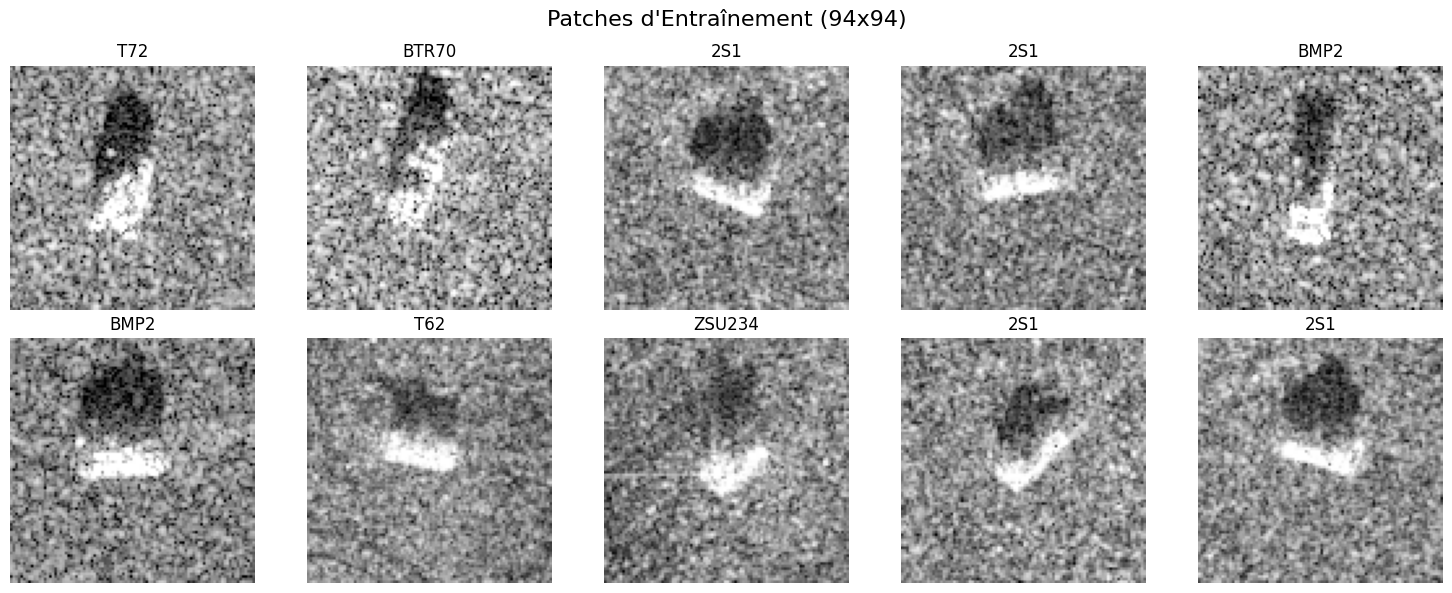


Affichage de 10 images aléatoires du test set...


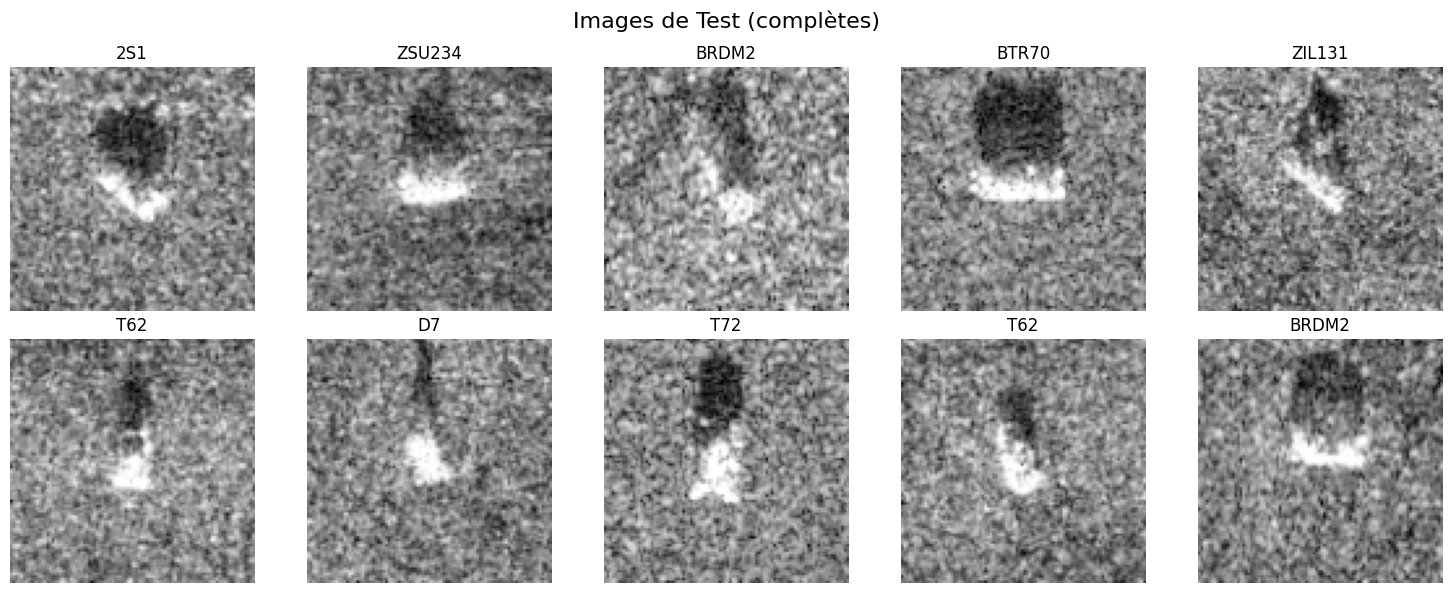

In [ ]:
def visualize_samples(dataset, class_names, num_samples=10, title="Échantillons"):
    """
    Affiche des échantillons aléatoires du dataset.
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    # Sélectionne des indices aléatoires
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx, ax in zip(indices, axes.flat):
        image, label = dataset[idx]

        # Conversion tensor → numpy
        if isinstance(image, torch.Tensor):
            image = image.squeeze().cpu().numpy()

        ax.imshow(image, cmap='gray')
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALISATION DES DONNÉES")
print("="*60)

# Visualise des patches d'entraînement
print("\nAffichage de 10 patches aléatoires du train set...")
visualize_samples(train_dataset, class_names, num_samples=10, title="Patches d'Entraînement (94x94)")

# Visualise des images de test
print("\nAffichage de 10 images aléatoires du test set...")
visualize_samples(test_dataset, class_names, num_samples=10, title="Images de Test (complètes)")


DISTRIBUTION DES CLASSES (IMAGES)

Ensemble d'ENTRAÎNEMENT (avant augmentation) :
  TOTAL : 2197
  2S1        :  237
  BMP2       :  196
  BRDM2      :  240
  BTR60      :  198
  BTR70      :  187
  D7         :  247
  T62        :  239
  T72        :  185
  ZIL131     :  229
  ZSU234     :  239

Ensemble de VALIDATION (avant augmentation) :
  TOTAL : 550
  2S1        :   62
  BMP2       :   37
  BRDM2      :   58
  BTR60      :   58
  BTR70      :   46
  D7         :   52
  T62        :   60
  T72        :   47
  ZIL131     :   70
  ZSU234     :   60

Ensemble de TEST :
  TOTAL : 2425
  2S1        :  274
  BMP2       :  195
  BRDM2      :  274
  BTR60      :  195
  BTR70      :  196
  D7         :  274
  T62        :  273
  T72        :  196
  ZIL131     :  274
  ZSU234     :  274


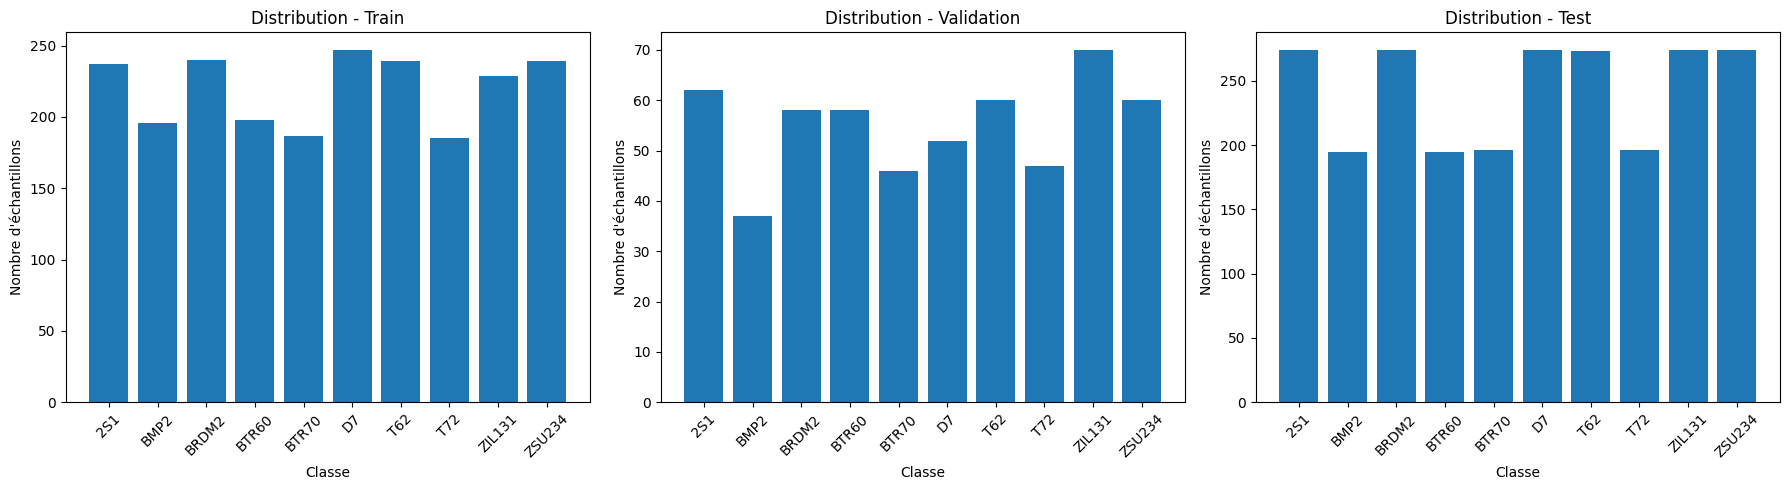

In [ ]:
def count_samples_per_class(dataset, class_names):
    """
    Compte le nombre d'échantillons par classe.
    """
    class_counts = np.zeros(len(class_names), dtype=int)

    # Pour les sous-ensembles créés avec random_split
    if hasattr(dataset, 'dataset'):
        for idx in dataset.indices:
            _, label = dataset.dataset[idx]
            class_counts[label] += 1
    else:
        # Pour les datasets complets
        for _, label in dataset:
            class_counts[label] += 1

    return class_counts

print("\n" + "="*60)
print("DISTRIBUTION DES CLASSES (IMAGES)")
print("="*60)

print("\nEnsemble d'ENTRAÎNEMENT (avant augmentation) :")
train_counts = count_samples_per_class(train_dataset_imgs, class_names)
print(f"  TOTAL : {np.sum(train_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {train_counts[i]:4d}")

print("\nEnsemble de VALIDATION (avant augmentation) :")
val_counts = count_samples_per_class(val_dataset_imgs, class_names)
print(f"  TOTAL : {np.sum(val_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {val_counts[i]:4d}")

print("\nEnsemble de TEST :")
test_counts = count_samples_per_class(test_dataset, class_names)
print(f"  TOTAL : {np.sum(test_counts)}")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:10s} : {test_counts[i]:4d}")

# Graphique de distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, counts, title in zip(axes,
                              [train_counts, val_counts, test_counts],
                              ['Train', 'Validation', 'Test']):
    ax.bar(class_names, counts)
    ax.set_title(f'Distribution - {title}')
    ax.set_xlabel('Classe')
    ax.set_ylabel('Nombre d\'échantillons')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Préparation des données pour le modèle




# Modèle

## Architecture du CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # Conv1: 1 → 16 channels, 5x5, ReLU, MaxPool
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2: 16 → 32 channels, 5x5, ReLU, MaxPool
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3: 32 → 64 channels, 6x6, ReLU, MaxPool
        self.conv3 = nn.Conv2d(32, 64, kernel_size=6, padding=0)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv4: 64 → 128 channels, 5x5, ReLU, Dropout
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=0)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        # Conv5: 128 → num_classes channels, 3x3
        self.conv5 = nn.Conv2d(128, num_classes, kernel_size=3, padding=0)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.dropout(self.relu4(self.conv4(x)))
        x = self.conv5(x)
        x = self.gap(x)
        x = self.flatten(x)
        return x

print("\n" + "="*60)
print("ARCHITECTURE DU MODÈLE")
print("="*60)

model = CNN(num_classes).to(device)
print(summary(model, (1, 94, 94)))


ARCHITECTURE DU MODÈLE
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 90, 90]             416
              ReLU-2           [-1, 16, 90, 90]               0
         MaxPool2d-3           [-1, 16, 45, 45]               0
            Conv2d-4           [-1, 32, 41, 41]          12,832
              ReLU-5           [-1, 32, 41, 41]               0
         MaxPool2d-6           [-1, 32, 20, 20]               0
            Conv2d-7           [-1, 64, 15, 15]          73,792
              ReLU-8           [-1, 64, 15, 15]               0
         MaxPool2d-9             [-1, 64, 7, 7]               0
           Conv2d-10            [-1, 128, 3, 3]         204,928
             ReLU-11            [-1, 128, 3, 3]               0
          Dropout-12            [-1, 128, 3, 3]               0
           Conv2d-13             [-1, 10, 1, 1]          11,530
AdaptiveAvgPool

## Compilation & Entraînement

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Évalue le modèle sur un ensemble de validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [21]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("\nDébut de l'entraînement...\n")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nEntraînement terminé !")


Début de l'entraînement...

Epoch [1/10]
  Train Loss: 0.5106, Train Acc: 0.8002
  Val Loss: 0.1054, Val Acc: 0.9622
Epoch [2/10]
  Train Loss: 0.1100, Train Acc: 0.9612
  Val Loss: 0.0714, Val Acc: 0.9737
Epoch [3/10]
  Train Loss: 0.0596, Train Acc: 0.9791
  Val Loss: 0.0329, Val Acc: 0.9870
Epoch [4/10]
  Train Loss: 0.0383, Train Acc: 0.9870
  Val Loss: 0.0745, Val Acc: 0.9768
Epoch [5/10]
  Train Loss: 0.0316, Train Acc: 0.9898
  Val Loss: 0.0142, Val Acc: 0.9950
Epoch [6/10]
  Train Loss: 0.0251, Train Acc: 0.9917
  Val Loss: 0.0107, Val Acc: 0.9961
Epoch [7/10]
  Train Loss: 0.0220, Train Acc: 0.9927
  Val Loss: 0.0249, Val Acc: 0.9913
Epoch [8/10]
  Train Loss: 0.0185, Train Acc: 0.9940
  Val Loss: 0.0157, Val Acc: 0.9937
Epoch [9/10]
  Train Loss: 0.0180, Train Acc: 0.9939
  Val Loss: 0.0159, Val Acc: 0.9948
Epoch [10/10]
  Train Loss: 0.0172, Train Acc: 0.9948
  Val Loss: 0.0229, Val Acc: 0.9925

Entraînement terminé !


# Résultats

## Analyse de l'entraînement

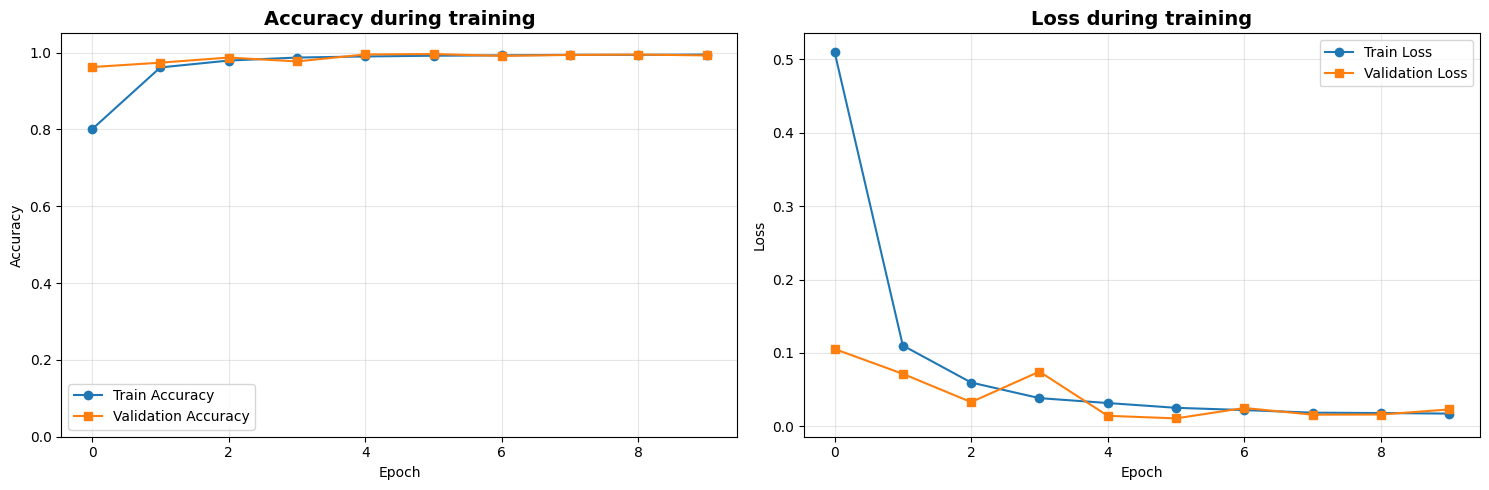

RÉSUMÉ DE L'ENTRAÎNEMENT

 MÉTRIQUES FINALES :
   Train Accuracy      : 0.9948 (99.48%)
   Validation Accuracy : 0.9925 (99.25%)
   Train Loss          : 0.017197
   Validation Loss     : 0.022925

 MEILLEURS RÉSULTATS:
   Meilleure Val Accuracy : 0.9961 (99.61%) à l'epoch 6
   Meilleure Val Loss     : 0.010685 à l'epoch 6

 CONVERGENCE:
   Epoch 1 → Epoch finale:
   - Train Accuracy: 0.8002 → 0.9948
   - Val Accuracy  : 0.9622 → 0.9925


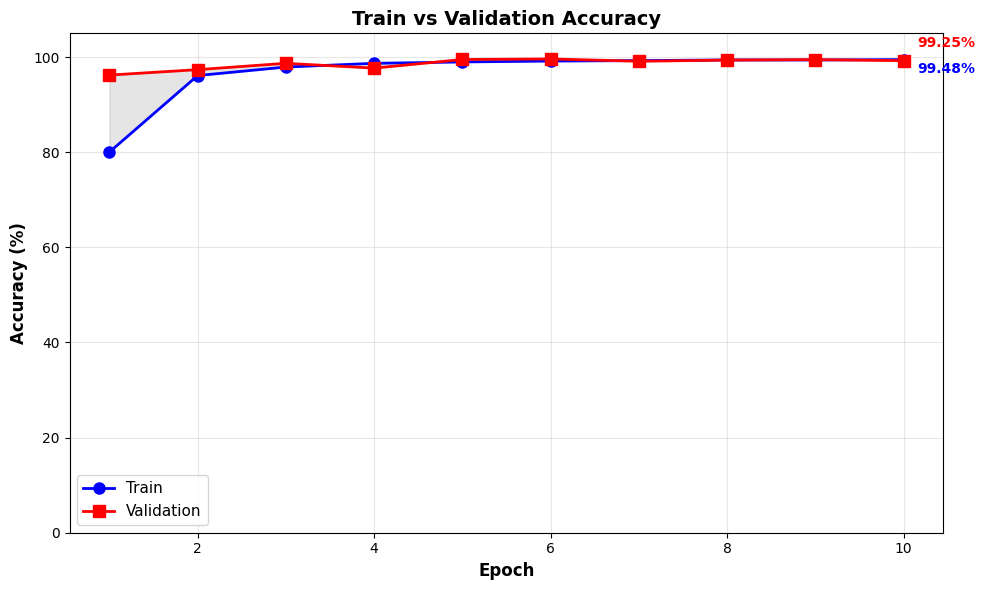

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[0].set_title('Accuracy during training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(history['train_loss'], label='Train Loss', marker='o')
axes[1].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Loss during training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 70)

# Métriques finales
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"\n MÉTRIQUES FINALES :")
print(f"   Train Accuracy      : {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Validation Accuracy : {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   Train Loss          : {final_train_loss:.6f}")
print(f"   Validation Loss     : {final_val_loss:.6f}")

# Métriques maximales
max_val_acc = max(history['val_acc'])
max_val_acc_epoch = history['val_acc'].index(max_val_acc) + 1
min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) + 1

print(f"\n MEILLEURS RÉSULTATS:")
print(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}")
print(f"   Meilleure Val Loss     : {min_val_loss:.6f} à l'epoch {min_val_loss_epoch}")

# Convergence
print(f"\n CONVERGENCE:")
print(f"   Epoch 1 → Epoch finale:")
print(f"   - Train Accuracy: {history['train_acc'][0]:.4f} → {final_train_acc:.4f}")
print(f"   - Val Accuracy  : {history['val_acc'][0]:.4f} → {final_val_acc:.4f}")

print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, len(history['train_acc']) + 1)
train_acc = np.array(history['train_acc']) * 100
val_acc = np.array(history['val_acc']) * 100

ax.plot(epochs, train_acc, 'b-o', label='Train', linewidth=2, markersize=8)
ax.plot(epochs, val_acc, 'r-s', label='Validation', linewidth=2, markersize=8)
ax.fill_between(epochs, train_acc, val_acc, alpha=0.2, color='gray')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Annoter le dernier point
ax.annotate(f'{train_acc[-1]:.2f}%',
            xy=(epochs[-1], train_acc[-1]),
            xytext=(10, -10),
            textcoords='offset points',
            fontweight='bold',
            color='blue')
ax.annotate(f'{val_acc[-1]:.2f}%',
            xy=(epochs[-1], val_acc[-1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontweight='bold',
            color='red')

plt.tight_layout()
plt.show()

## Évaluation sur le Test Set


ÉVALUATION SUR L'ENSEMBLE DE TEST

 RÉSULTATS SUR TEST SET:
   Test Accuracy : 0.9662 (96.62%)
   Test Loss     : 0.153772

MATRICE DE CONFUSION


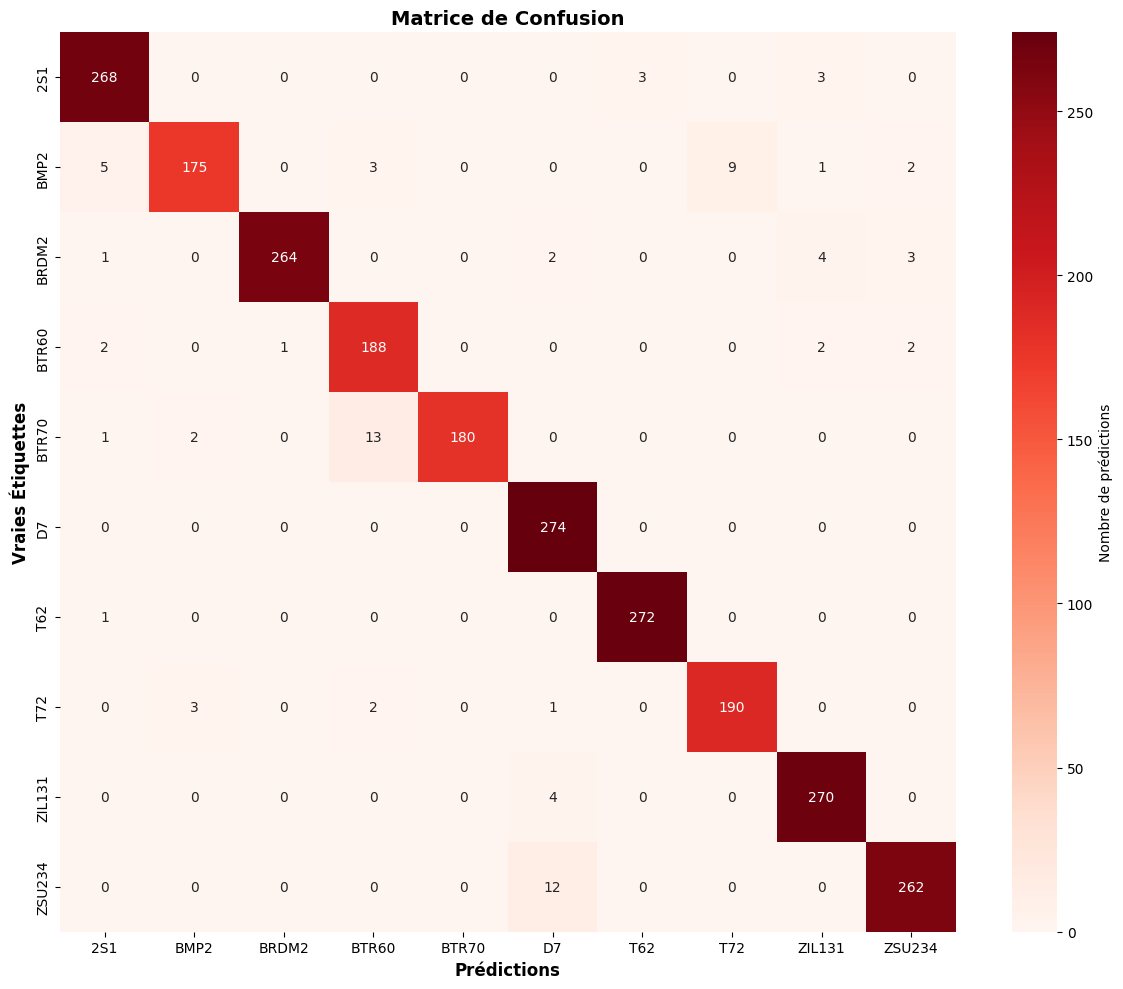

In [23]:
print("\n" + "=" * 70)
print("ÉVALUATION SUR L'ENSEMBLE DE TEST")
print("=" * 70)

test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n RÉSULTATS SUR TEST SET:")
print(f"   Test Accuracy : {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test Loss     : {test_loss:.6f}")


print("\n" + "=" * 70)
print("MATRICE DE CONFUSION")
print("=" * 70)

# Récupérer les vrais labels et prédictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Nombre de prédictions'})
plt.xlabel('Prédictions', fontsize=12, fontweight='bold')
plt.ylabel('Vraies Étiquettes', fontsize=12, fontweight='bold')
plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



## Rapport de classification détaillé


RAPPORT DE CLASSIFICATION PAR CLASSE

              precision    recall  f1-score   support

         2S1     0.9640    0.9781    0.9710       274
        BMP2     0.9722    0.8974    0.9333       195
       BRDM2     0.9962    0.9635    0.9796       274
       BTR60     0.9126    0.9641    0.9377       195
       BTR70     1.0000    0.9184    0.9574       196
          D7     0.9352    1.0000    0.9665       274
         T62     0.9891    0.9963    0.9927       273
         T72     0.9548    0.9694    0.9620       196
      ZIL131     0.9643    0.9854    0.9747       274
      ZSU234     0.9740    0.9562    0.9650       274

    accuracy                         0.9662      2425
   macro avg     0.9662    0.9629    0.9640      2425
weighted avg     0.9671    0.9662    0.9661      2425

ACCURACY PAR CLASSE
2S1             : 268/274 = 0.9781 (97.81%)
BMP2            : 175/195 = 0.8974 (89.74%)
BRDM2           : 264/274 = 0.9635 (96.35%)
BTR60           : 188/195 = 0.9641 (96.41%)
BTR70 

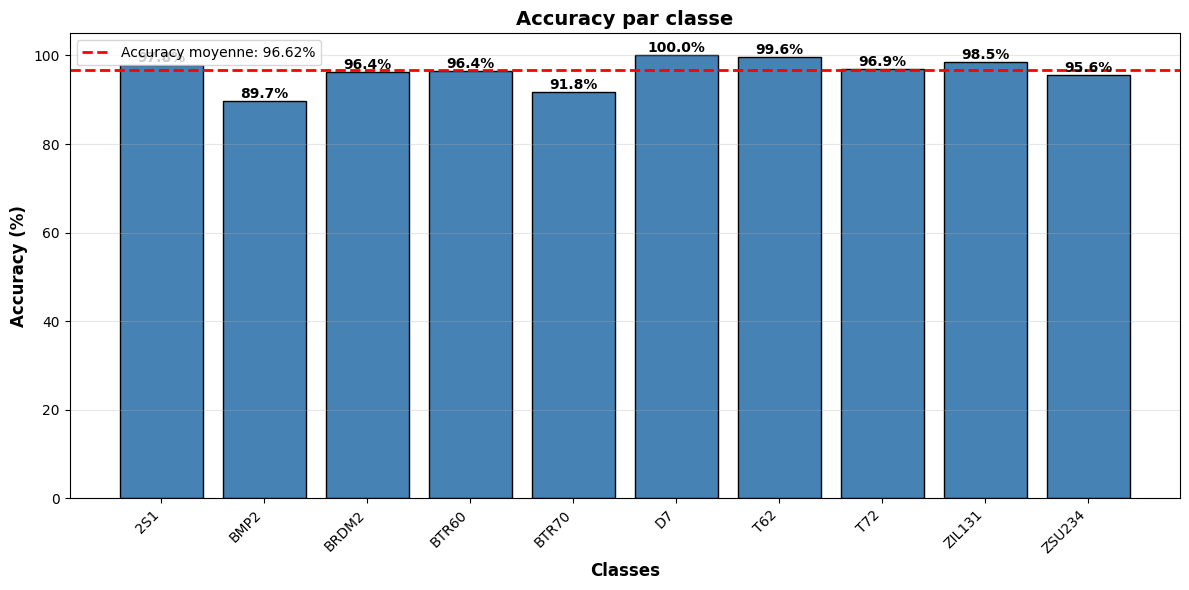


ANALYSE DES ERREURS

 Nombre total d'erreurs : 82/2425 (3.38%)

 TOP 5 CONFUSIONS:
   1. BTR70 → BTR60 : 13 fois
   2. ZSU234 → D7 : 12 fois
   3. BMP2 → T72 : 9 fois
   4. BMP2 → 2S1 : 5 fois
   5. ZIL131 → D7 : 4 fois


In [24]:
print("\n" + "=" * 70)
print("RAPPORT DE CLASSIFICATION PAR CLASSE")
print("=" * 70 + "\n")

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

print("=" * 70)
print("ACCURACY PAR CLASSE")
print("=" * 70)

class_accuracies = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy = class_accuracies[i]
    print(f"{class_name:15s} : {correct:3d}/{total:3d} = {accuracy:.4f} ({accuracy*100:.2f}%)")

print("=" * 70)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracies * 100, color='steelblue', edgecolor='black')
plt.axhline(y=test_acc*100, color='red', linestyle='--', linewidth=2, label=f'Accuracy moyenne: {test_acc*100:.2f}%')
plt.xlabel('Classes', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Accuracy par classe', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALYSE DES ERREURS")
print("=" * 70)

# Trouver les erreurs
errors = np.where(y_true != y_pred)[0]
num_errors = len(errors)
total_samples = len(y_true)

print(f"\n Nombre total d'erreurs : {num_errors}/{total_samples} ({num_errors/total_samples*100:.2f}%)")

if num_errors > 0:
    print(f"\n TOP 5 CONFUSIONS:")

    # Matrice de confusion sans la diagonale
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)

    # Trouver les 5 plus grandes confusions
    top_confusions = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm_errors[i, j] > 0:
                top_confusions.append((cm_errors[i, j], class_names[i], class_names[j]))

    top_confusions.sort(reverse=True)

    for idx, (count, true_class, pred_class) in enumerate(top_confusions[:5], 1):
        print(f"   {idx}. {true_class} → {pred_class} : {count} fois")
else:
    print("\n AUCUNE ERREUR !")

print("=" * 70)

